# Geo-Referencing and Digitization of Scanned Maps

## Table of Contents <a class="anchor" id="0"></a>
* [Introduction](#1) 
* [Data Used](#2)
* [Imports](#3)
* [Create Masks](#4) 
* [Create Template Image](#5)
* [Prepare Search Region ](#6)
* [Match Template Multiscale](#7)
* [Georeference Image](#8) 
* [Digitize Image](#9)
* [Conclusion](#10)

### Introduction<a class="anchor" id="1"></a>

This sample guide explains the steps to automate the geo-referencing and digitization of scanned maps. Lets understand some common terminologies first:
    * Scanned Map: A scanned map can be referred to any type of scientific paper map that is scanned to digital format.
    * Geo-referencing: Geo-referencing is a process of assigning the real-world coordinates to the scanned map.
    * Digitizing: Digitization of a scanned map is a process of converting geo-referenced data into digital format and
        store it as the spatial data(shapefile).
        
As a lot of images that contains geographical information is avaiable but cannot be used as spatial data, this process uses computer vision techniques to automatically extract details from a set of images also finds the control points and registers the images to any part of the world onto the world map and hence overlay the hotspots depicted in the scanned images onto the world map.

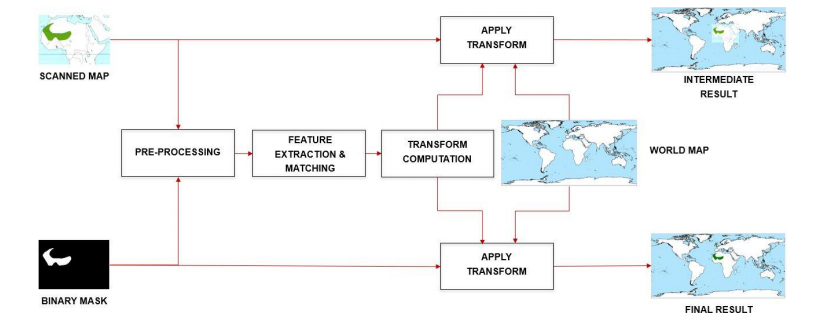

This guide illustrates the stepwise use of six APIs that are capable of geo-reference and digitize the scanned map image on the globe.


### Data Used<a class="anchor" id="2"></a>

The data used for this sample are the scanned images from the handbook called "Mammals of the world" which contains the information of mice species along with the images depicting species region on the map. We extracted the images from the scanned book in order to geo-reference and digitize the species on the world map.

Below are some sample scanned maps with species region 

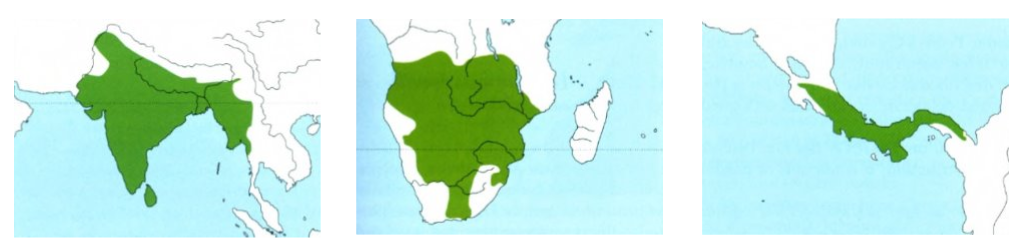

<b>Image 1. Bandicota bengalensis ( Bandicoot Rat ) </b> <br/>
<b>Image 2. Saccostomus campestris ( Southern African Pouched Mouse )</b> <br/>
<b>Image 3. Tylomys watsoni ( Watson’s Climbing Rat ) </b> <br/>

## Implementation in arcgis.learn

Lets geo-reference and digitize the scanned maps with arcgis.learn

### Imports<a class="anchor" id="3"></a>

Please import the "ScannedMapDigitizer" class from arcgis.learn module.


In [22]:
#making it from arcgis.learn
from scannedmapdigitizer import ScannedMapDigitizer

##### Object initialization

The parameters to be passed are:

* input_folder: The path to the folder that contains scanned map images
* output_folder: The path to the folder where intermediate results and output should get generated with image name

Note: Intermediate results are the output from the below-mentioned methods and required for each upcoming step as input.


In [ ]:
smd = ScannedMapDigitizer(r"path_to_scanned_maps", r"path_to_output_folder" )

### Create Masks <a class="anchor" id="4"></a>

This method is capable of extracting colored masks from the scanned maps and producing a binary mask for the same.

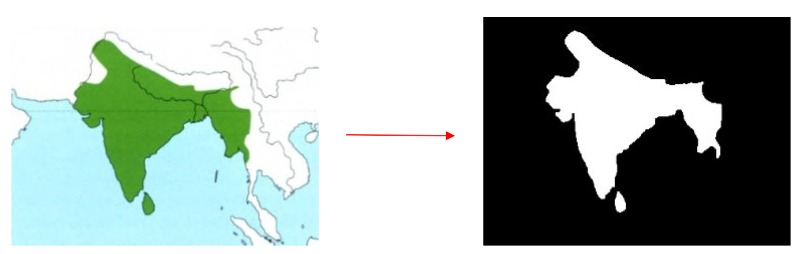

* The parameters to be passed are

    * color_list:
    A list containing number of different colors(r, g, b). For an example if a image contains two colors to
    represent two different species. The list should contains RGB values for both the color as tuple.
    syntax: [(r, g, b), (r1, g1, b1)]<br/><br/>
    * color_delta: 
    A value which is responsible for generating a threshold value(range) for a specific color.
    Default value is 60.<br>
    Note: The minimum value of color_delta is 0, where using 0 means masking the image for the same color used in the color
    list, and increasing the value will expand the threshold/range of the color, which will be useful for extracting the
    nearest color shades. The value can be tweaked accordingly as using a bigger value can end up masking the unwanted 
    color pixel also. 
    <br/><br/>
    * kernel_size: 
    A list of integers(size of the kernel) of length 2.Used in removing the noise from the masked image as
    the value at the 0th index is responsible for the "closing" operation and the value at the 1st index is responsible
    for "opening" opertion. Default value is None. <br/><br/>
    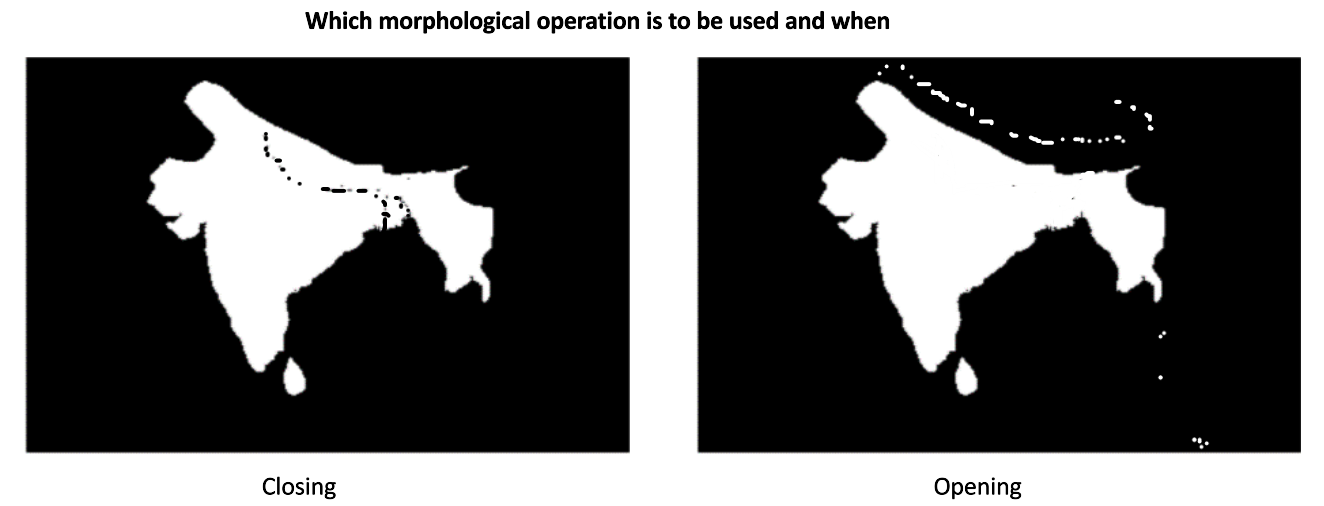
    By increasing/decreasing the value of kernel_size parameter we can remove the noise inside and outside the region and
    hence can generate a better mask for the image. Although the use of kernel_size is only advised when there is a lot of
    noise available after masking the image with color thresholding.
    <br/><br/>
    * kernel_type: 
    A string value defining the type/shape of the kernel. kernel type can be "rect", "elliptical" and
    "cross". Default value is "rect". <br/><br/>
    * show_result: 
    A boolean value. Set True to visualize results and set False to skip visualizing results. <br/><br/>
    
* The function generates a folder with name "masks" with binary masks for all the colors and mask_color_details.h5
    






For a given scanned map image the method loops over the color in the color_list and generates a color threshold with color_delta, which is used to generate binary masks for that specific color region. The mask is then further processed to remove noise from inside and outside of the region using kernel_size and kernel_type parameters.


In [ ]:
smd.create_mask(color_list=[[100, 164, 8]], color_delta=70, kernel_size=[3, 3], kernel_type="rect", show_result=True)

### Create Template Image <a class="anchor" id="4"></a>

This method is capable of extracting land region masks from the scanned maps and producing a binary mask for the same.

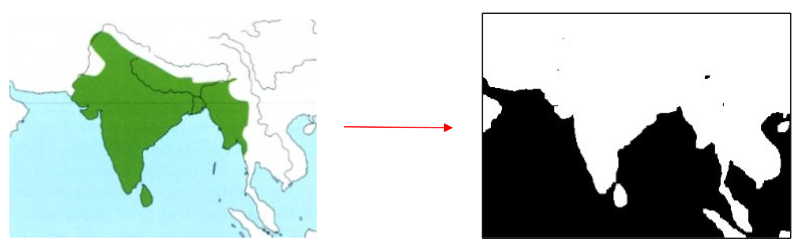

* The parameters to be passed are

    * color:
    A list containing r, g, b value for land color. The color parameter is required for extracting the land region and 
    generating the binary mask.
    syntax: [r, g, b]<br/><br/>
    * color_delta: 
    A value which is responsible for generating a threshold value(range) for a specific color.
    Default value is 10.
    <br/><br/>
    * kernel_size: 
    An integers(size of the kernel).Used in removing the noise from the masked image. The morphological operation
    used is dilation. Default value is 2. <br/><br/>
    * show_result: 
    A boolean value. Set True to visualize results and set False to skip visualizing results. <br/><br/>
    
* The function generates a folder with the name "template_image" with binary masks for the land region.
    






This method is capable of generating templates from scanned maps and color masks, these templates can be used in template matching.

In [39]:
smd.create_template_image([254, 254,254], 10, 4, show_result= True)

### Prepare Search Region <a class="anchor" id="6"></a>

The method prepares the search region which is a world image in our case. It can produce the binary image of the land region which will be used as the bigger region upon which the template will be matched.  

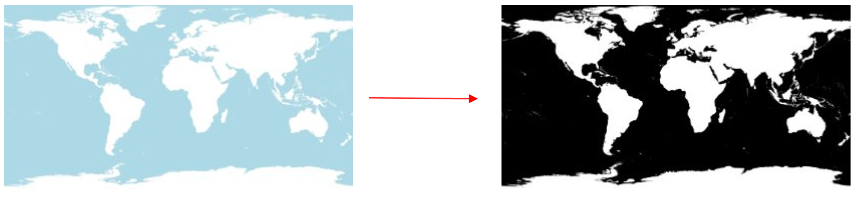

* The parameters to be passed are

    * search_image: Path to the world image.  <br/><br/>
    
* The function generates a folder with the name "search_region" with binary masks of the world image.


In [27]:
smd.prepare_search_region(r"..\world_map_img.jpg", show_result=True)

### Match Template Multiscale <a class="anchor" id="7"></a>

This method is capable of finding the location of the best match of a smaller image (template) in a larger image(world map) assuming it exists in the larger image. Multiple scales of the bigger image are used for this task because template matching is not scale-invariant.

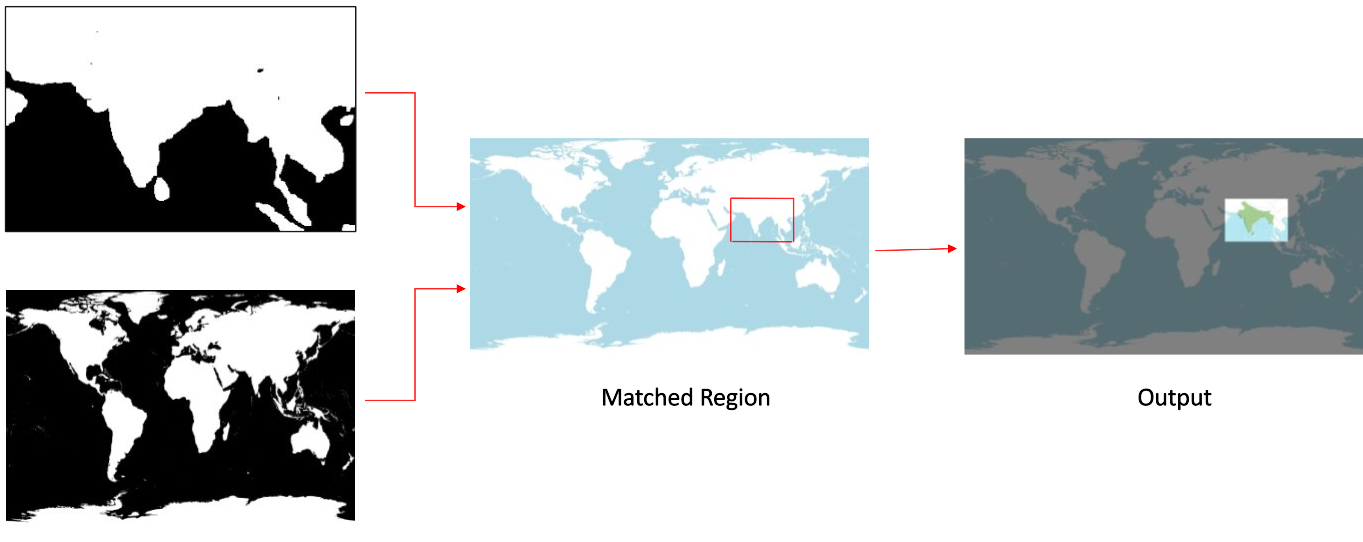


The final output is generated using reference homography, the 4 pairs of points obtained from matching the entire homogenized scanned map template image with the homogenized world map image.


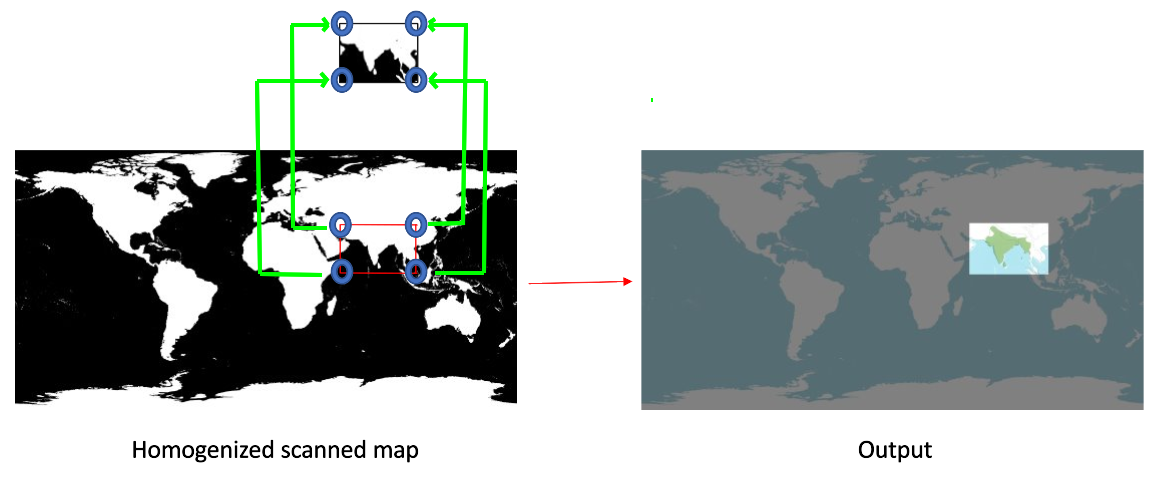


* The parameters to be passed are

    * min_scale: An integer that represents minimum value to start scaling<br/><br/>
    * max_scale: An integer that represents maximum value to end scaling<br/><br/>
    * num_scales: An integer that represents number of scales required<br/><br/>
    * show_result: 
    A boolean value. Set True to visualize results and set False to skip visualizing results. <br/><br/>
    
    
* The function generates a folder with name the "template_match" with homogenized world image and "reference_homography.h5" that contains x-y coordinates of the matched template on world image.
    






In [28]:
smd.match_template_multiscale(0.2, 2.0, 40, show_result=True)

### Georeference Image <a class="anchor" id="8"></a>

This method is capable of estimating the control point pairs by traversing the contours of a scanned image and finding the corresponding matches on the world map ROI image. The world map ROI image is obtained by padding the detected bounding box in the template matching step. The control points are filtered by removing the outliers. Filtered control points and world image extent are then used to generate the image location on the world map. 

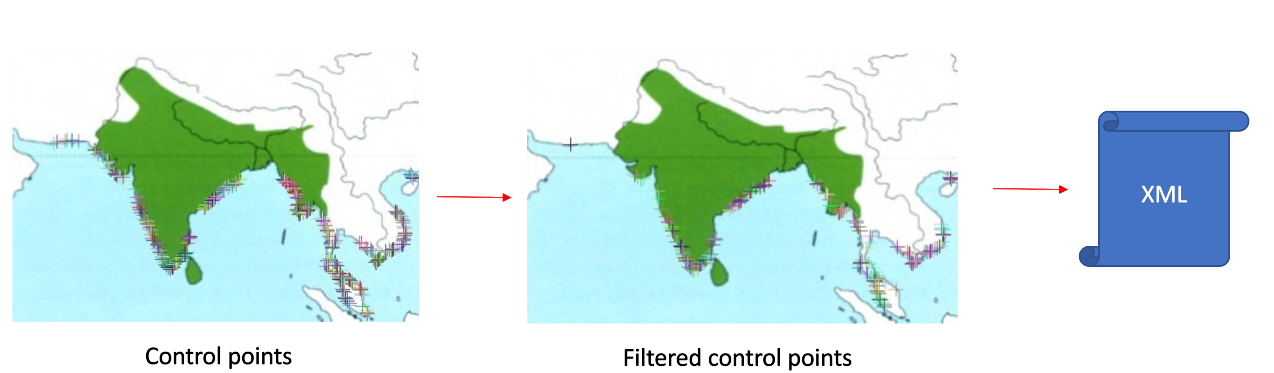




* The parameters to be passed are

    * extent: A dictionary that contains the extent of the world image used. <br/><br/>
    * padding_param: An tuple that contains x-padding and y-padding at 0th and 1st index respectively. These padding
      values are used to create world map ROI that is used to for computing refined homography<br/><br/>
    * show_result: 
    A boolean value. Set True to visualize results and set False to skip visualizing results. <br/><br/>
    
    
* The function generates a folder with the name "georeference_image" with warped specie image and an XML file that contains the geographical coordinates of the image. Open the georeferenced image inside the ArcgisPRO tool.
    






In [42]:
extent = {
        'spatialReference': {'wkid': 4326},
         'xmin': -180,
         'ymin': -89,
         'xmax': 180,
         'ymax': 85
    }

In [44]:
smd.georeference_image(extent, (150, 50), show_result=True)

### Digitize Image <a class="anchor" id="9"></a>

This method is the final step in the pipeline that is capable of mapping the species region on the world map using the computed homography matrices. Also, it generates the shapefiles for the specie region that can be used with the ArcgisPRO tool to visualize and further edit. Also, it generates a combined shapefile for all the species region available inside the input folder.

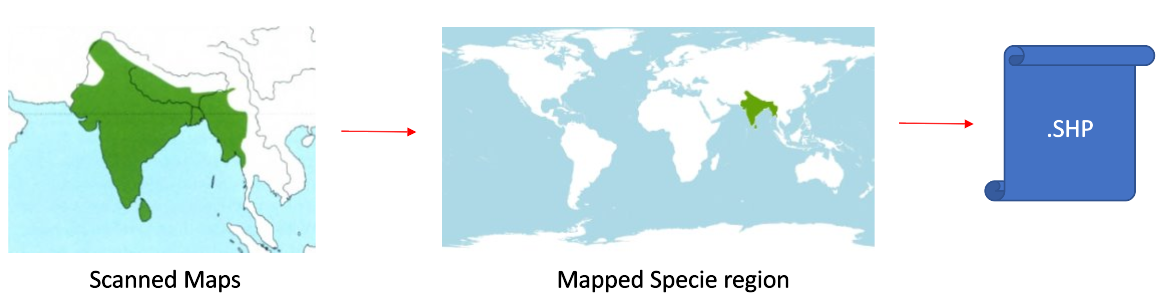




* The parameters to be passed are
    * show_result: 
    A boolean value. Set True to visualize results and set False to skip visualizing results. <br/><br/>
    
    
* The function generates a folder with name "digitize_image" with mapped specie region on world image and region-wise shapefile.
    






In [31]:
smd.digitize_image(show_result=True)

### Conclusion <a class="anchor" id="10"></a>

In this sample notebook, we have automated the process of mapping species region distribution on the world map. We defined functions for each step in the workflow and executed the steps. This sample can be a starting point for developers to perform similar registration tasks by tuning the parameters. The use-case of registering satellite images on the world can also be accomplished using a similar workflow with few changes in the feature detection and matching steps.   